In [1]:
import pandas as pd
import jsonlines
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

### Load METAMAP data

1. Load the FZ corpus
2. Load the split version
3. Load the MedQA queries

### 1

In [4]:
df_fz = pd.read_csv("/scratch/s190619/Data_etc/FindZebra/FZ_corpus_evaluation.tsv",sep='\t')
df_fz.head()

,pid,title,passage,cui,source,source_url,classification_map
0,0,Kernicterus,Kernicterusrefers to brain damage that may occ...,C0022610,gard,https://rarediseases.info.nih.gov/diseases/683...,"{""mesh"": [""D007647""], ""umls"": [""C0022610""], ""o..."
1,1,47 XXX syndrome,"47 XXX syndrome, also called trisomy X or trip...",C0221033,gard,https://rarediseases.info.nih.gov/diseases/567...,"{""mesh"": [""C535318""], ""umls"": [""C0221033""], ""o..."
2,2,Pseudoxanthoma elasticum,"Pseudoxanthoma elasticum, PXE, is an inherited...",C0033847,gard,https://rarediseases.info.nih.gov/diseases/964...,"{""mesh"": [""D011561""], ""omim"": [""264800""], ""orp..."
3,3,Smith-Magenis Syndrome,SummaryClinical characteristics.Smith-Magenis ...,C0795864,gene_reviews,https://www.ncbi.nlm.nih.gov/books/NBK1310/,"{""mesh"": [""D058496""], ""synonyms"": [""del(17)(p1..."
4,4,Smith-Lemli-Opitz Syndrome,SummaryClinical characteristics.Smith-Lemli-Op...,C0175694,gene_reviews,https://www.ncbi.nlm.nih.gov/books/NBK1143/,"{""mesh"": [""D019082""], ""synonyms"": [""SLOS""]}"


In [5]:
df_fz.shape

(30658, 7)

### 2


In [167]:
df_fz_split = pd.read_csv("/scratch/s190619/Data_etc/FindZebra/FZ_corpus_split_w_info.tsv",sep='\t').drop("Unnamed: 0",axis=1)
df_fz_split.columns = ['pid', 'apid', 'passage', 'title', 'cui']
df_fz_split.head()

,pid,apid,passage,title,cui
0,0,0,Kernicterusrefers to brain damage that may occ...,Kernicterus,C0022610
1,1,0,Physiologic neonatal jaundice (which can affec...,Kernicterus,C0022610
2,2,0,"However, in some babies, bilirubin levels may ...",Kernicterus,C0022610
3,3,0,Risk factors for severe jaundice and higher bi...,Kernicterus,C0022610
4,4,0,"After a few days of jaundice, toxic levels of ...",Kernicterus,C0022610


### How to join the passages with the ranking

In [161]:
dfd = pd.read_csv(rankings, sep="\t",header=None, names=["qid", "pid", "ranking_score"])
dfd.head()

,qid,pid,ranking_score
0,0,816822,1
1,0,116321,2
2,0,726790,3
3,0,207526,4
4,0,382520,5


In [164]:
dfd2 = dfd.join(df_fz_split.set_index("pid"), on="pid")#.join(df_fz[["pid","cui"]].set_index("pid"),on="apid")

In [165]:
dfd2.head()

,qid,pid,ranking_score,apid,passages,title,cui
0,0,816822,1,29022,The girl was brought to hospital at age 6 days...,"PSEUDOHYPOALDOSTERONISM, TYPE I, AUTOSOMAL REC...",C1449843
1,0,116321,2,3206,The 19-month-old girl was admitted with purpur...,COMPLEMENT FACTOR D DEFICIENCY,C0398764
2,0,726790,3,25265,This 14-year-old girl had severe refractory se...,GLYCOSYLPHOSPHATIDYLINOSITOL BIOSYNTHESIS DEFE...,C1853205
3,0,207526,4,5481,A girl had recurrent episodes of repeated vomi...,DIHYDROLIPOAMIDE DEHYDROGENASE DEFICIENCY,C0034345
4,0,382520,5,11956,"(9)In 1983, a 4-year-old girl in the USA was a...",Coenurosis in humans,NaN


### 3

In [8]:
dfj_MM = pd.read_csv("/scratch/s190619/Data_etc/MedQA/disorders_table_dev-test.csv", converters={'cui_METAMAP': eval})
dfj_MM.head(50)
dfj_MM.shape

(611, 12)

In [9]:
CUIs_found_in_MedQA = list(dfj_MM["CUI"].dropna().unique())
for MM_cui in dfj_MM["cui_METAMAP"]:
    for cui in MM_cui:
        CUIs_found_in_MedQA.append(cui)
CUIs_found_in_MedQA = set(CUIs_found_in_MedQA)

CUIs_found_in_FindZebra = list(df_fz["cui"].unique())

cui_intersection = [x for x in CUIs_found_in_MedQA if x in CUIs_found_in_FindZebra]
num_cui_MedQA = len(CUIs_found_in_MedQA)
num_cui_FZ = len(CUIs_found_in_FindZebra)
num_cui_inter = len(cui_intersection)
num_cui_MedQA_not_FZ = num_cui_MedQA - num_cui_inter

print("Number of CUIs in FindZebra corpus: %d" %(num_cui_FZ))
print("Number of CUIs in MedQA queries (with METAMAP cuis): %d" %(num_cui_MedQA))
print("Number of CUIs found in both (intersection): %d" %(num_cui_inter))
print("Number of CUIs in MedQA not in FindZebra: %d" %(num_cui_MedQA_not_FZ))

Number of CUIs in FindZebra corpus: 14966
Number of CUIs in MedQA queries (with METAMAP cuis): 670
Number of CUIs found in both (intersection): 334
Number of CUIs in MedQA not in FindZebra: 336


# Functions

In [45]:
import math

In [153]:
def get_top_10_third(qid, rankings, queries, documents, offset = 0, topk = 10, get_passages = False):
    '''
    qid: the query id represented by an integer
    rankings: the dataframe containing the rankings created by FAISS indexing
    queries: the dataframe containing all the queries with query ids
    documents: the dataframe containing the FindZebra corpus
    topk: defines how many of the top results gets retrieved
    '''
    qid_disorders = list(queries["qid"].unique())
    
    if qid in qid_disorders:
        q = queries[queries["qid"]==qid]["query"].iloc[0]
        a = queries[queries["qid"]==qid]["answer"].iloc[0]
        a_cui = queries[queries["qid"]==qid]["CUI"].iloc[0]
        METAMAP_cuis = queries[queries["qid"]==qid]["cui_METAMAP"].iloc[0]
        #print(METAMAP_cuis)

        df_tmp = rankings[rankings["qid"]==qid].iloc[offset:offset+topk]
        docs = []
        doc_cuis = []
        
        df_tmp = df_tmp.join(documents.set_index("pid"), on="pid")
        doc_cuis = list(df_tmp["cui"].dropna())
        
        if get_passages == True:
            for i in range(len(df_tmp)):
                docs.append(documents[documents["pid"]==df_tmp["pid"].iloc[i]]["passage"].iloc[0])
            #doc_cuis.append(documents[documents["pid"]==df_tmp["pid"].iloc[i]]["cui"].iloc[0])

        return q, a, a_cui, METAMAP_cuis, docs, doc_cuis

In [168]:
def evaluate_METAMAP(rankings_path='',FZ=False,FZ_reqs=None, CUIs_not_found_in_FZ=0, topk = 100):
    if FZ:
        try: FZ_reqs.iloc[0]
        except: print("Please provide FZ requests")
    else:
        assert rankings_path != ''
        df_rankings = pd.read_csv(rankings_path, sep="\t",header=None, names=["qid", "pid", "ranking_score"])
    answers = []
    occurences = []
    ranks = []
    k=0
    for qid in tqdm(list(dfj_MM["qid"].unique())):
        try:
            if not FZ:
                q, a, a_cui, METAMAP_cuis, docs, doc_cuis = get_top_10_third(qid, df_rankings, dfj_MM_relevant, df_fz_split, offset = 0, topk = topk, get_passages = False)
            else:
                q, a, a_cui, METAMAP_cuis, doc_cuis = get_top_10_FZ(qid, FZ_reqs, dfj_MM_relevant, df_fz, offset = 0, topk = topk, get_passages = False)
            answers.append(a)
#             if a_cui in cui_intersection or any(x in cui_intersection for x in METAMAP_cuis):
#             occurences.append(sum([1 for cui in doc_cuis if a_cui == cui or cui in METAMAP_cuis]))
            occ = []
            rank_j = []
            for i in range(len(doc_cuis)):
                cui = doc_cuis[i]
                if cui == a_cui or cui in METAMAP_cuis:
                    occ.append(1)
                    rank_j.append(i)
            occurences.append(sum(occ))
            ranks.append(rank_j)
#             else:
#                 occurences.append(-1)
        except:
            k+=1
            continue
    
    values, counts = np.unique(occurences, return_counts=True)
    counts[0] = counts[0]-CUIs_not_found_in_FZ
    print(values)
    print(counts)
    plt.bar(values[1:],counts[1:])
    
    return values, counts, ranks

In [53]:
#Used to get FindZebra requests
def get_requests(MM_df, api_key, response_format = 'json', num_docs = 10, num_requests = 10, cui_only = False):
    
    qids = []
    num_errors = 0
    
    if num_requests == -1:
        num_requests = MM_df.shape[0]
        
    if type(num_docs) != str:
        num_docs = str(num_docs)
        
    ploads = {'api_key':api_key,
              'response_format':response_format,
              'rows':num_docs}
    reqs = []
    print("Collecting FindZebra requests...")
    for i in tqdm(range(num_requests)):
#        try:
        query = MM_df['query'].iloc[i]
        ploads['q'] = query
        r = requests.get('https://www.findzebra.com/api/v1/query',params=ploads)
        if r.json()['responseHeader']['status'] == 400:
            num_errors += 1
            continue
            
        if cui_only == True:
            reqs_tmp = []
            for j in range(len(r.json()['response']['docs'])):
                try:
                    reqs_tmp.append(r.json()['response']['docs'][j]['cui'])
                except:
                    reqs_tmp.append('')
            reqs.append(reqs_tmp)
            qids.append(MM_df['qid'].iloc[i])
            #reqs.append([r.json()['response']['docs'][i] for i in range(len(r.json()['response']['docs']))])
        else:
            reqs.append(r)
#        except:
#            print("[%s] does not exist.\n\n" %query)
    return qids, reqs


def get_top_10_FZ(qid, rankings, queries, documents, offset = 0, topk = 10, get_passages = False):
    '''
    qid: the query id represented by an integer
    rankings: the dataframe containing the rankings created by FAISS indexing
    queries: the dataframe containing all the queries with query ids
    documents: the dataframe containing the FindZebra corpus
    topk: defines how many of the top results gets retrieved
    '''
    qid_disorders = list(queries["qid"].unique())
    if qid in qid_disorders:
        q = queries[queries["qid"]==qid]["query"].iloc[0]
        a = queries[queries["qid"]==qid]["answer"].iloc[0]
        a_cui = queries[queries["qid"]==qid]["CUI"].iloc[0]
        METAMAP_cuis = queries[queries["qid"]==qid]["cui_METAMAP"].iloc[0]
        doc_cuis = rankings[rankings["qid"]==qid]["cuis"].iloc[0][:topk]
        return q, a, a_cui, METAMAP_cuis, doc_cuis

In [13]:
def MRR(rankings, topk=100000):
    MRR = 0
    for ranks in rankings:
        if ranks != []:
            if ranks[0] < topk:
                MRR += 1/(ranks[0]+1) # Because Python counts from 0
    MRR = MRR*1/len(rankings)
    return MRR

In [14]:
def MCRR(rankings, topk):
    MCRR = 0
    for ranks in rankings:
        if ranks != []:
            for rank in ranks:
                if rank < topk:
                    MCRR += 1/(rank+1) # Because Python counts from 0
    MCRR = MCRR*1/len(rankings)
    return MCRR

# Evaluate FindZebra

In [23]:
# Create a new dataset which have relevant CUIs only
tmp_list = []
for i in range(dfj_MM.shape[0]):
    #tmp_list.append([x if x == dfj_MM["CUI"].iloc[i] or x in dfj_MM["cui_METAMAP"].iloc[i] else np.nan for x in CUIs_found_in_MedQA])
    tmp_list.append([x for x in cui_intersection if x == dfj_MM["CUI"].iloc[i] or x in dfj_MM["cui_METAMAP"].iloc[i]])
#dfj_MM["all_cui"] = 

In [24]:
dfj_MM["relevant_cuis"] = tmp_list

In [25]:
dfj_MM_relevant = dfj_MM[dfj_MM["relevant_cuis"].map(len) != 0]

In [26]:
dfj_MM_relevant.drop_duplicates(subset=['query']).shape

(394, 13)

In [25]:
%%time
FZ_qids, FZ_cuis = get_requests(dfj_MM_relevant,
                       '1050b7b5-3988-4ceb-b844-de87977e731d',
                       num_docs = 100,
                       num_requests = -1,
                       cui_only = True)
FZ_reqs = pd.DataFrame(list(zip(FZ_qids, FZ_cuis)),columns = ['qid','cuis'])

  0%|          | 0/394 [00:00<?, ?it/s]

CPU times: user 15min 14s, sys: 17.5 s, total: 15min 32s
Wall time: 27min 18s


  0%|          | 0/611 [00:00<?, ?it/s]

[0 1 2 3 4 5]
[205  94  13   1   1   1]


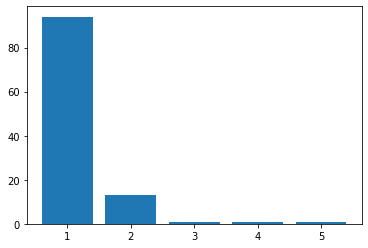

In [26]:
val_fz, count_fz, ranks_fz = evaluate_METAMAP(rankings_path='',FZ=True,FZ_reqs=FZ_reqs,topk=100)

[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 19 20 21 23 24 26 27
 30 31 33 34 36 37 38 43 44 45 46 48 50 53 55 60 61 62 63 66 70 71 73 74
 76 82 83 84 86 88 89 90 91 96]
[16  9  9  9  8  4  4  1  1  4  3  1  1  1  2  2  2  2  1  3  2  1  2  3
  1  1  2  3  1  2  1  1  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  1]


<BarContainer object of 58 artists>

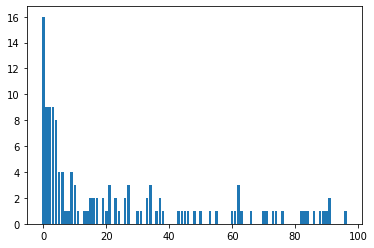

In [27]:
rankings_fz = [x for y in ranks_fz for x in y if y != []]
values, counts = np.unique(rankings_fz, return_counts=True)
print(values)
print(counts)
plt.bar(values,counts)

# Evaluate ColBERT

In [7]:
# df_rankings = pd.read_csv("ranking.tsv", sep="\t",header=None, names=["qid", "pid", "ranking_score"])
# df_rankings_ft = pd.read_csv("ranking_finetuned_medQA.tsv", sep="\t",header=None, names=["qid", "pid", "ranking_score"])
# df_rankings_bioBERT = pd.read_csv("ranking_bioBERT.tsv", sep="\t",header=None, names=["qid", "pid", "ranking_score"])
# df_rankings_bioBERT_32k = pd.read_csv("ranking_bioBERT_32k.tsv", sep="\t",header=None, names=["qid", "pid", "ranking_score"])

In [12]:
# rankings_path = "/scratch/s190619/Data_etc/ColBERT/retrievals/dev-test/"

In [17]:
N = 100

  0%|          | 0/611 [00:00<?, ?it/s]

[0 1 2]
[376  16   2]


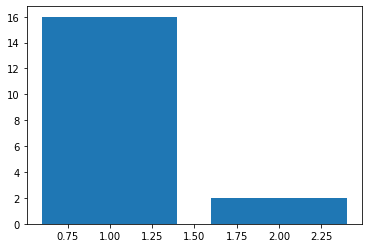

In [170]:
rankings = "/scratch/s190619/Data_etc/ColBERT/retrievals/FZ_Corpus_Model1_2.cosine.30x200k/" + "ranking.tsv"
val1, count1, ranks1 = evaluate_METAMAP(rankings, topk = N, FZ=False)

[ 0  2  3  6 14 17 18 19 40 46 47 51 53 80 81 86 92 93]
[1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]


<BarContainer object of 18 artists>

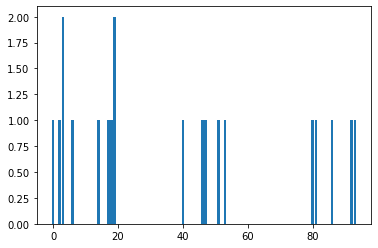

In [171]:
rankings1 = [x for y in ranks1 for x in y if y != []]
values, counts = np.unique(rankings1, return_counts=True)
print(values)
print(counts)
plt.bar(values,counts)

  0%|          | 0/611 [00:00<?, ?it/s]

[0 1 2 3]
[374  17   2   1]


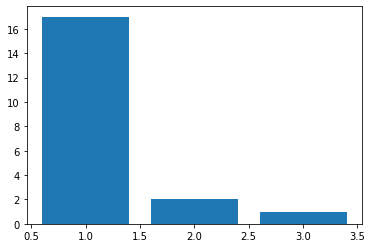

In [175]:
rankings = "/scratch/s190619/Data_etc/ColBERT/retrievals/FZ_Corpus_Model4_2.cosine.30x200k/" + "ranking.tsv"
val4, count4, ranks4 = evaluate_METAMAP(rankings, topk = N, FZ=False)

[ 1  8  9 10 11 16 17 21 22 24 26 27 32 35 37 46 47 57 60 65 72]
[2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]


<BarContainer object of 21 artists>

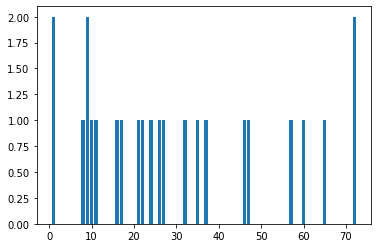

In [176]:
rankings4 = [x for y in ranks4 for x in y if y != []]
values, counts = np.unique(rankings4, return_counts=True)
print(values)
print(counts)
plt.bar(values,counts)

  0%|          | 0/611 [00:00<?, ?it/s]

[0 1 2]
[351  36   7]


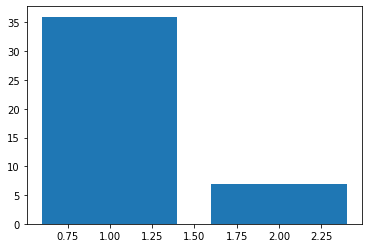

In [173]:
rankings = "/scratch/s190619/Data_etc/ColBERT/retrievals/FZ_Corpus_Model8.cosine.30x200k/" + "ranking.tsv"
val8, count8, ranks8 = evaluate_METAMAP(rankings, topk = N, FZ=False)

[ 0  3  4  7  9 10 14 15 17 19 22 23 24 26 29 31 33 35 36 40 41 45 49 52
 53 55 58 62 64 73 77 81 87 88 91 96]
[1 1 1 2 2 1 1 1 2 3 1 1 1 1 2 2 1 1 4 1 2 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1]


<BarContainer object of 36 artists>

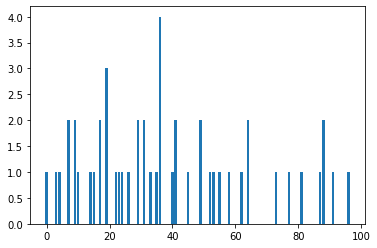

In [174]:
rankings8 = [x for y in ranks8 for x in y if y != []]
values, counts = np.unique(rankings8, return_counts=True)
print(values)
print(counts)
plt.bar(values,counts)

  0%|          | 0/611 [00:00<?, ?it/s]

[0 1 2 3 4 5 6 7]
[320  49  13   6   1   2   2   1]


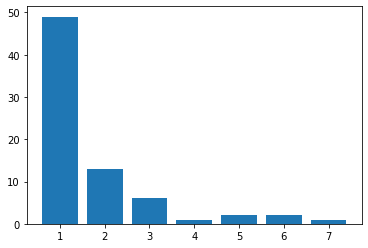

In [181]:
rankings = "/scratch/s190619/Data_etc/ColBERT/retrievals/FZ_Corpus_Model9_1.cosine.12x200k/" + "ranking.tsv"
val9, count9, ranks9 = evaluate_METAMAP(rankings, topk = N, FZ=False)

[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 17 18 19 21 22 24 25 26 27
 29 30 32 33 34 35 36 38 39 40 42 43 44 45 46 47 48 50 51 52 53 54 55 58
 59 60 61 64 65 66 69 70 72 74 77 78 79 80 81 82 84]
[7 3 3 5 3 1 2 2 4 3 1 2 1 1 3 2 1 2 1 1 1 4 2 2 3 2 1 1 1 3 1 2 1 1 3 1 3
 1 1 4 2 2 1 2 2 1 1 1 2 3 1 1 2 1 1 1 1 2 4 1 1 1 1 3 2]


<BarContainer object of 65 artists>

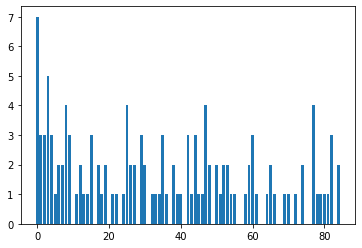

In [182]:
rankings9 = [x for y in ranks9 for x in y if y != []]
values, counts = np.unique(rankings9, return_counts=True)
print(values)
print(counts)
plt.bar(values,counts)

  0%|          | 0/611 [00:00<?, ?it/s]

[0 1 2 3 4 5 6 7]
[316  53  15   2   3   2   1   2]


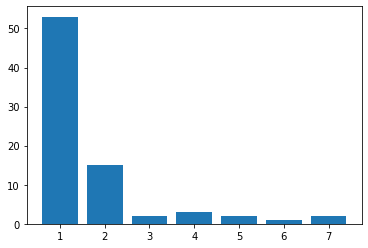

In [179]:
rankings = "/scratch/s190619/Data_etc/ColBERT/retrievals/FZ_Corpus_Model10_1.cosine.12x200k/" + "ranking.tsv"
val10, count10, ranks10 = evaluate_METAMAP(rankings, topk = N, FZ=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 18 19 20 21 23 24 25 26 28
 29 30 36 38 39 40 42 43 45 46 47 49 50 52 53 54 55 59 60 62 64 65 67 68
 70 71 73 74 75 78 79 80 81 82 83 84 85 87]
[5 5 2 3 4 6 5 1 3 2 3 3 1 5 2 4 1 2 4 2 1 1 1 1 2 1 2 1 2 1 1 1 2 2 2 3 2
 1 1 1 2 2 2 2 1 1 3 1 2 3 1 1 2 3 1 1 3 1 4 1 1 1]


<BarContainer object of 62 artists>

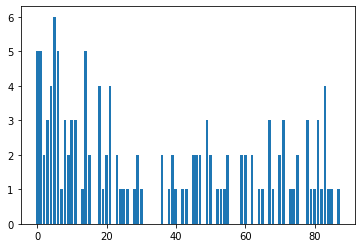

In [180]:
rankings10 = [x for y in ranks10 for x in y if y != []]
values, counts = np.unique(rankings10, return_counts=True)
print(values)
print(counts)
plt.bar(values,counts)

In [52]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

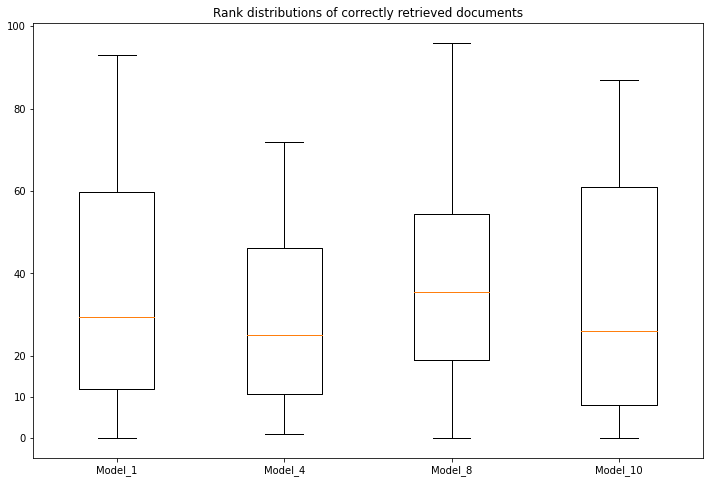

In [183]:

my_dict = {#'FindZebra': rankings_fz,
           'Model_1': rankings1, 
          'Model_4': rankings4,
          'Model_8': rankings8,
          'Model_10': rankings10}

fig, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.set_title("Rank distributions of correctly retrieved documents")
ax.set_yticks([0,10,20,40,60,80,100])

fig.savefig("Figures/Retrieval_boxplot.jpg")
fig.show()

In [184]:
topk = 10
print("MRR score:")
#print("FindZebra: ", round(MRR(ranks_fz,topk),5))
print("Model 1: ", round(MRR(ranks1,topk),5))
print("Model 4: ", round(MRR(ranks4,topk),5))
print("Model 8: ", round(MRR(ranks8,topk),5))
print("Model 10: ", round(MRR(ranks10,topk),5))
# print("Model 1: ", MRR(ranks1))
# print("Model 2: ", MRR(ranks2))
# print("Model 2_1: ", MRR(ranks2_1))
# print("Model 3: ", MRR(ranks3))

MRR score:
Model 1:  0.00491
Model 4:  0.00333
Model 8:  0.00482
Model 10:  0.02775


In [185]:
print("MCRR score:")
#print("FindZebra: ", round(MCRR(ranks_fz,topk),5))
print("Model 1: ", round(MCRR(ranks1,topk),5))
print("Model 4: ", round(MCRR(ranks4,topk),5))
print("Model 8: ", round(MCRR(ranks8,topk),5))
print("Model 10: ", round(MCRR(ranks10,topk),5))

MCRR score:
Model 1:  0.00491
Model 4:  0.00333
Model 8:  0.00482
Model 10:  0.03068


# Look at retrievals manually

In [202]:
qid = 8
topk = 10
a_cui = dfj_MM_relevant[dfj_MM_relevant["qid"]==qid]["CUI"].iloc[0]
MM_cui = dfj_MM_relevant[dfj_MM_relevant["qid"]==qid]["cui_METAMAP"].iloc[0]
print(a_cui,MM_cui)
model = rankings_path + "Ranking_Model3.tsv"
df_rankings = pd.read_csv(model, sep="\t",header=None, names=["qid", "pid", "ranking_score"])
df_tmp = df_rankings[df_rankings["qid"]==qid].iloc[0:topk]
df_tmp = df_tmp.join(df_fz.set_index("pid"), on="pid")
df_tmp.head(topk)

C0042961 ['C0042961']


,qid,pid,ranking_score,title,passage,cui,source,source_url,classification_map
8000,8,1727,1,Retroperitoneal fibrosis,Retroperitoneal fibrosis is a disorder in whic...,C0494949,medlineplus,https://medlineplus.gov/genetics/condition/ret...,"{""gard"": [""9568""], ""mesh"": [""C537375""], ""omim""..."
8001,8,12844,2,Toxic megacolon,Toxic megacolon is an acute form of colonic di...,C0025162,wikipedia,https://en.wikipedia.org/wiki/Toxic_megacolon,"{""mesh"": [""D008532""], ""umls"": [""C0025162""], ""i..."
8002,8,11713,3,Valentino's syndrome,"In medicine, Valentino's syndrome is pain pres...",NaN,wikipedia,https://en.wikipedia.org/wiki/Valentino%27s_sy...,"{""wikidata"": [""Q7911051""]}"
8003,8,7497,4,Abdominal aortic aneurysm,Abdominal aortic aneurysm (AAA or triple A) is...,C0162871,wikipedia,https://en.wikipedia.org/wiki/Abdominal_aortic...,"{""gard"": [""9181""], ""mesh"": [""D017544""], ""umls""..."
8004,8,5148,5,TIGLIC ACIDEMIA,This is another defect in the degradation of i...,C1848793,omim,https://www.omim.org/entry/275190,"{""mesh"": [""C536921""], ""omim"": [""275190""]}"
8005,8,11220,6,Indigestion,"Upset stomachIndigestion, also known as dyspep...",C0013395,wikipedia,https://en.wikipedia.org/wiki/Indigestion,"{""mesh"": [""D004415""], ""umls"": [""C0013395""], ""i..."
8006,8,1338,7,"SUPERIOR TRANSVERSE SCAPULAR LIGAMENT, CALCIFI...",Cohen et al. (1997) described a 58-year-old ma...,C1866424,omim,https://www.omim.org/entry/601708,"{""mesh"": [""C566638""], ""omim"": [""601708""]}"
8007,8,11849,8,Budd–Chiari syndrome,"Budd–Chiari syndrome is a very rare condition,...",C0019154,wikipedia,https://en.wikipedia.org/wiki/Budd%E2%80%93Chi...,"{""gard"": [""5968""], ""mesh"": [""D006502""], ""umls""..."
8008,8,27370,9,Abdominal aortic aneurysm,Abdominal aortic aneurysms (AAAs) are aneurysm...,C0162871,gard,https://rarediseases.info.nih.gov/diseases/918...,"{""mesh"": [""D017544""], ""omim"": [""100070""], ""uml..."
8009,8,5497,10,ERYTHROCYTE LACTATE TRANSPORTER DEFECT,A number sign (#) is used with this entry beca...,C1855577,omim,https://www.omim.org/entry/245340,"{""mesh"": [""C565449""], ""omim"": [""245340""], ""orp..."


In [203]:
q = dfj_MM_relevant[dfj_MM_relevant["qid"]==qid]["query"].iloc[0]
print(q)
print(dfj_MM_relevant[dfj_MM_relevant["qid"]==qid]["answer"].iloc[0])
print('')
print(df_tmp.reset_index().loc[1,"passage"])

ِA 62-year-old man comes to the emergency department because of colicky pain in the lower abdomen and abdominal distension for the past 12 hours. He has chronic constipation for which he takes lactulose and senna laxatives. His temperature is 37.1°C (98.7°F), blood pressure is 110/60 mm Hg and pulse is 85/min. On physical examination, there is diffuse abdominal distension and tenderness, and bowel sounds are faint. His plain abdominal radiograph is shown. Which of the following is the most likely diagnosis?
Volvulus

Toxic megacolon is an acute form of colonic distension. It is characterized by a very dilated colon (megacolon), accompanied by abdominal distension (bloating), and sometimes fever, abdominal pain, or shock.Toxic megacolon is usually a complication of inflammatory bowel disease, such as ulcerative colitis and, more rarely, Crohn's disease, and of some infections of the colon, including Clostridium difficile infections, which have led to pseudomembranous colitis. Other form

In [176]:
index = -1
for j in range(len(FZ_cuis)):
    if FZ_cuis [index].json()['responseHeader']['params']['q'] == q:
        index = j
        break

if index != -1:
    print(FZ_cuis[index].json()['responseHeader'])
    for i in range(topk):
        print(FZ_cuis[index].json()['response']['docs'][i]['cui'])
        print(FZ_cuis[index].json()['response']['docs'][i]['title'])
        print('')

In [201]:
index = 3
print(FZ_cuis[index].json()['responseHeader'])
for i in range(topk):
    #print(FZ_cuis[index].json()['response']['docs'][i]['cui'])
    print(FZ_cuis[index].json()['response']['docs'][i]['title'])
    print('')

{'status': 0, 'QTime': 13, 'params': {'q': 'ِA 62-year-old man comes to the emergency department because of colicky pain in the lower abdomen and abdominal distension for the past 12 hours. He has chronic constipation for which he takes lactulose and senna laxatives. His temperature is 37.1°C (98.7°F), blood pressure is 110/60 mm Hg and pulse is 85/min. On physical examination, there is diffuse abdominal distension and tenderness, and bowel sounds are faint. His plain abdominal radiograph is shown. Which of the following is the most likely diagnosis?', 'fl': ['title', 'display_content', 'genes', 'retrieved_date', 'source_url', 'source', 'cui', 'score'], 'start': '0', 'sort': 'score desc', 'rows': '100', 'wt': 'json'}}
Constipation

Acute abdomen

Constipation in children

Encopresis

Toxic megacolon

Bowel obstruction

Appendicitis

Abdominal aortic aneurysm

Ischemic colitis

Umbilical hernia

